In [ ]:
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import numpy as np
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
# from keras.utils import to_categorical
from keras.layers import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout

# small library for seeing the progress of loops.
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()


<ipython-input-1-d18c043a3036>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm().pandas()


0it [00:00, ?it/s]

## Data Loading

In [ ]:
def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text


In [ ]:

def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [ caption ]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions


## Data Preprocessing

In [ ]:
def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):
            img_caption.replace("-"," ")
            desc = img_caption.split()
            #converts to lowercase
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string
            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions


In [ ]:
def text_vocabulary(descriptions):
    # build vocabulary of all unique words
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab


In [ ]:
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Length of descrptions and vocabulary

In [ ]:
dataset_text = "/content/drive/MyDrive/TELUGU/Flickr8k_text"
dataset_images = "/content/drive/MyDrive/TELUGU/Flickr8k_Dataset/Flicker8k_Dataset"
#we prepare our text data
filename = dataset_text + "/" + "Flickr8k.token.txt"
#loading the file that contains all data
#mapping them into descriptions dictionary img to 5 captions
descriptions = all_img_captions(filename)
print("Length of descriptions =" , len(descriptions))
#cleaning the descriptions
clean_descriptions = cleaning_text(descriptions)

#building vocabulary
vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))
#saving each description to file
save_descriptions(clean_descriptions, "/content/drive/MyDrive/TELUGU/descriptions.txt")


Length of descriptions = 8092
Length of vocabulary =  8763


## Extracting Feature Vectors

In [ ]:
def extract_features(directory):
        model = Xception( include_top=False, pooling='avg' )
        features = {}
        for img in tqdm(os.listdir(directory)):
            filename = directory + "/" + img
            image = Image.open(filename)
            image = image.resize((299,299))
            image = np.expand_dims(image, axis=0)
            #image = preprocess_input(image)
            image = image/127.5
            image = image - 1.0
            feature = model.predict(image)
            features[img] = feature
        return features


In [ ]:
features = extract_features(dataset_images)
dump(features, open("/content/drive/MyDrive/TELUGU/features.p","wb"))
features = load(open("/content/drive/MyDrive/TELUGU/features.p","rb"))


83683744/83683744 [==============================] - 1s 0us/step


In [ ]:
features = load(open("/content/drive/MyDrive/TELUGU/features.p","rb"))


## Loading Dataset for Training

In [ ]:
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos


In [ ]:
def load_clean_descriptions(filename, photos):
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):
        words = line.split()
        if len(words)<1 :
            continue
        image, image_caption = words[0], words[1:]
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)
    return descriptions


In [ ]:
def load_features(photos):
    #loading all features
    all_features = load(open("/content/drive/MyDrive/TELUGU/features.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features


In [ ]:
filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"
#train = loading_data(filename)
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("/content/drive/MyDrive/TELUGU/descriptions.txt", train_imgs)
train_features = load_features(train_imgs)


## Tokenizing Vocabulary

In [ ]:
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc


In [ ]:
from keras.preprocessing.text import Tokenizer

In [ ]:
def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer


In [ ]:
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('/content/drive/MyDrive/TELUGU/tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size


7577

In [ ]:
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
max_length = max_length(descriptions)
max_length


32

## Create Data generator

In [ ]:
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield ([input_image, input_sequence], output_word)
def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)
#You can check the shape of the input and output for your model
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape


((47, 2048), (47, 32), (47, 7577))

## Defining Xception+LSTM model

In [ ]:
from tensorflow.keras.utils import plot_model
# define the captioning model
def define_model(vocab_size, max_length):
    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    print(model.summary())
    plot_model(model, to_file='/content/drive/MyDrive/TELUGU/model.png', show_shapes=True)
    return model


In [ ]:
import tensorflow as tf

In [ ]:
checkpoint_path = "/content/drive/MyDrive/TELUGU/Xcep.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                  save_weights_only=True,
                                                  verbose=1)

In [ ]:
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)
model = define_model(vocab_size, max_length)
print(model,'model')

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  32
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32)]                 0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 32, 256)              1939712   ['input_2[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 2048)                 0         ['input_1[0][0]'] 

In [ ]:
model.load_weights(checkpoint_path)

## Training

In [ ]:
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)
model = define_model(vocab_size, max_length)
print(model,'model')
epochs = 10
steps = len(train_descriptions)
# making a directory models to save our models
#os.mkdir("/content/drive/MyDrive/TELUGU/models")
for i in range(epochs):
    model.load_weights(checkpoint_path)
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1,callbacks=[cp_callback])


Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  32
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 32)]                 0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 32, 256)              1939712   ['input_8[0][0]']             
                                                                                                  
 dropout_2 (Dropout)         (None, 2048)                 0         ['input_7[0][0]'

<ipython-input-44-7bc293873693>:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1,callbacks=[cp_callback])


6000/6000 [==============================] - ETA: 0s - loss: 2.8384
Epoch 1: saving model to /content/drive/MyDrive/TELUGU/Xcep.ckpt
6000/6000 [==============================] - ETA: 0s - loss: 2.7991
Epoch 1: saving model to /content/drive/MyDrive/TELUGU/Xcep.ckpt
6000/6000 [==============================] - ETA: 0s - loss: 2.7689
Epoch 1: saving model to /content/drive/MyDrive/TELUGU/Xcep.ckpt
6000/6000 [==============================] - ETA: 0s - loss: 2.7428
Epoch 1: saving model to /content/drive/MyDrive/TELUGU/Xcep.ckpt
6000/6000 [==============================] - ETA: 0s - loss: 2.7206
Epoch 1: saving model to /content/drive/MyDrive/TELUGU/Xcep.ckpt
6000/6000 [==============================] - ETA: 0s - loss: 2.6995
Epoch 1: saving model to /content/drive/MyDrive/TELUGU/Xcep.ckpt
6000/6000 [==============================] - ETA: 0s - loss: 2.6843
Epoch 1: saving model to /content/drive/MyDrive/TELUGU/Xcep.ckpt
6000/6000 [==============================] - ETA: 0s - loss: 2.6665
E

In [ ]:
model.save("/content/drive/MyDrive/TELUGU/xce_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.load_weights(checkpoint_path)

## Testing and Evaluation

In [ ]:
from PIL import Image

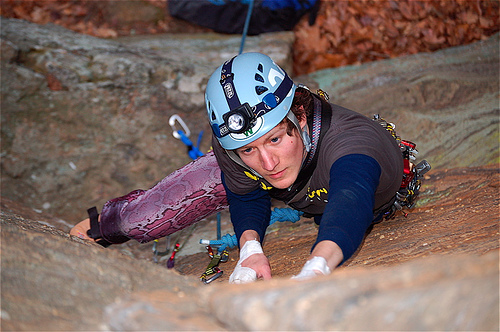

In [ ]:
from PIL import Image
img=Image.open('/content/drive/MyDrive/TELUGU/Flickr8k_Dataset/Flicker8k_Dataset/111537222_07e56d5a30.jpg')
#imagePath = '/content/drive/MyDrive/TELUGU/Flickr8k_Dataset/Flicker8k_Dataset/3738685861_8dfff28760.jpg'
#img = Image.open(imagePath)
img


In [ ]:
!python3 /content/drive/MyDrive/TELUGU/test.py -i /content/drive/MyDrive/TELUGU/Flickr8k_Dataset/Flicker8k_Dataset/111537222_07e56d5a30.jpg

2024-03-05 18:39:22.612224: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 18:39:22.612330: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 18:39:22.616763: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-05 18:39:24.866598: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
1/1 [==============================] - 1s 1s/step



start man in red shirt is standing on the top of the top of the top of the mountains end


In [ ]:
!python3 /content/drive/MyDrive/TELUGU/test.py -i /content/drive/MyDrive/TELUGU/rose.png

2024-03-05 18:39:39.050616: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 18:39:39.050681: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 18:39:39.052057: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-05 18:39:40.341941: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
1/1 [==============================] - 3s 3s/step



start two dogs are playing on the grass end


In [ ]:
!python3 /content/drive/MyDrive/TELUGU/test.py -i /content/drive/MyDrive/TELUGU/rose.png

2024-02-29 14:57:43.162519: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-29 14:57:43.162609: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-29 14:57:43.164140: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-29 14:57:44.484325: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
1/1 [==============================] - 1s 1s/step



start two dogs are playing on the grass end


In [ ]:
!pip install keras

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.applications.xception import Xception
from keras.models import load_model
from pickle import load
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse



In [ ]:
ap = argparse.ArgumentParser()


In [ ]:
ap.add_argument('-i', '--image', required=True, help="Image Path")


_StoreAction(option_strings=['-i', '--image'], dest='image', nargs=None, const=None, default=None, type=None, choices=None, required=True, help='Image Path', metavar=None)

In [ ]:
def extract_features(filename, model):
        #try:
        image = Image.open(filename)
        #except:
            #print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4:
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature


In [ ]:
def word_for_id(integer, tokenizer):
 for word, index in tokenizer.word_index.items():
     if index == integer:
         return word
 return None


In [ ]:
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text


1/1 [==============================] - 1s 1s/step



start two dogs are playing together in the grass end


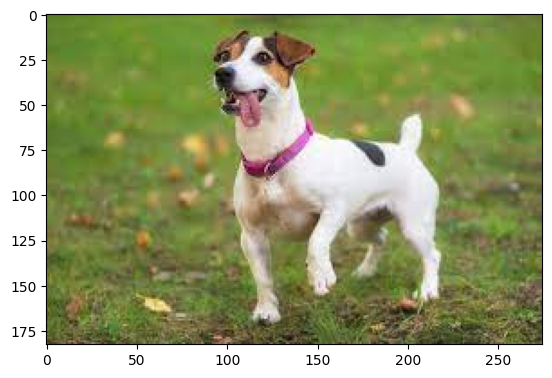

In [ ]:
max_length = 32
tokenizer = load(open("/content/drive/MyDrive/TELUGU/tokenizer.p","rb"))
model = load_model('/content/drive/MyDrive/TELUGU/xce_model.h5')
xception_model = Xception(include_top=False, pooling="avg")
photo = extract_features(img_path, xception_model)
img = Image.open(img_path)
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)


In [ ]:
import keras

In [ ]:
from keras.applications.xception import Xception
from keras.models import load_model
from pickle import load
import numpy as np
from PIL import Image

def new_caption(image_path, model, tokenizer, max_length):

    # Load VGG16 model and restructure it to output features from the second-to-last layer
    xception_model = Xception()
    xception_model = keras.models.Model(inputs=xception_model.inputs, outputs=xception_model.layers[-2].output)

    # Display the image
    img = load_img(image_path)
    plt.imshow(img)

    # Load and preprocess the image
    image = load_img(image_path, target_size=( 299, 299))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)

    # Extract features from the image using VGG16
    feature = xception_model.predict(image, verbose=0)

    # Generate caption using the trained model
    caption =generate_desc(model, tokenizer, feature, max_length)

    return caption

'start two children are playing in the hay end'

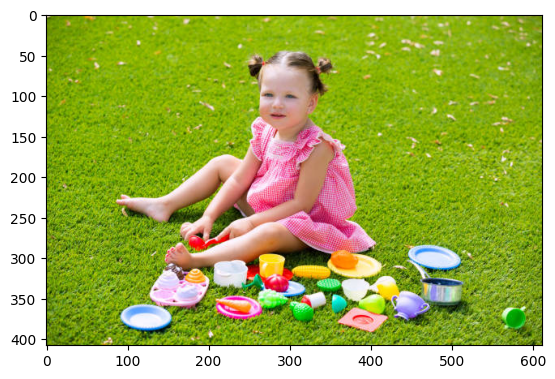

In [ ]:
new_caption("/content/drive/MyDrive/TELUGU/Flickr8k_Dataset/test_images/8.jpg",model,tokenizer,max_length)